## Detecting Spurious Antisense:

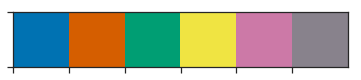

In [1]:
import sys
import os
from glob import glob
from collections import defaultdict, Counter, namedtuple
import itertools as it
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#88828c'])
cmap = ListedColormap(pal.as_hex()[:2])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

#### ERCC antisense reads:

We can simply count the number of reads that map antisense to the ERCC spikein controls to estimate antisense here

In [10]:
ercc_bams = [
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/ERCC92/201901_col0_2916.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/ERCC92/201901_col0_2917.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/ERCC92/201901_col0_2918.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/ERCC92/201901_col0_2919.bam',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180405_FAH59362_WT_Col0_2917/aligned_data/ERCC92/201903_col0_2917_exp2.bam',    
]

In [11]:
def get_antisense(bam_fn):
    antisense = 0
    with pysam.AlignmentFile(bam_fn) as bam:
        mapped = bam.mapped
        for aln in bam.fetch():
            if aln.is_reverse:
                antisense += 1
    return antisense, mapped

total_mapped = 0
total_antisense = 0
for bam in ercc_bams:
    a, t = get_antisense(bam)
    total_mapped += t
    total_antisense += a
print(total_antisense, total_antisense / total_mapped * 100)

2 0.021175224986765485


## Antisense at RCA

As an example of a highly expressed gene with no genuine antisense annotations, we use RCA.

In [12]:
rca_locus = ['2', 16_570_746, 16_573_692]

In [21]:
def intersect(inv_a, inv_b):
    a_start, a_end = inv_a
    b_start, b_end = inv_b
    if a_end < b_start or a_start > b_end:
        return 0
    else:
        s = max(a_start, b_start)
        e = min(a_end, b_end)
        return e - s


def intersect_spliced_invs(invs_a, invs_b):
    score = 0
    invs_a = iter(invs_a)
    invs_b = iter(invs_b)
    a_start, a_end = next(invs_a)
    b_start, b_end = next(invs_b)
    while True:
        if a_end < b_start:
            try:
                a_start, a_end = next(invs_a)
            except StopIteration:
                break
        elif a_start > b_end:
            try:
                b_start, b_end = next(invs_b)
            except StopIteration:
                break
        else:
            score += intersect([a_start, a_end], [b_start, b_end])
            if a_end > b_end:
                try:
                    b_start, b_end = next(invs_b)
                except StopIteration:
                    break
            else:
                try:
                    a_start, a_end = next(invs_a)
                except StopIteration:
                    break
    return score


def bam_cigar_to_invs(aln):
    invs = []
    start = aln.reference_start
    end = aln.reference_end
    strand = '-' if aln.is_reverse else '+'
    left = start
    right = left
    for op, ln in aln.cigar:
        if op in (1, 4, 5):
            # does not consume reference
            continue
        elif op in (0, 2, 7, 8):
            # consume reference but do not add to invs yet
            right += ln
        elif op == 3:
            invs.append([left, right])
            left = right + ln
            right = left
    if right > left:
        invs.append([left, right])
    assert invs[0][0] == start
    assert invs[-1][1] == end
    return start, end, strand, np.array(invs)


PARSED_ALN = namedtuple('Aln', 'chrom start end read_id strand invs')

def parse_pysam_aln(aln):
    chrom = aln.reference_name
    read_id = aln.query_name
    start, end, strand, invs = bam_cigar_to_invs(
        aln)
    return PARSED_ALN(chrom, start, end, read_id, strand, invs)

counts = Counter()

with pysam.AlignmentFile('/cluster/ggs_lab/mtparker/analysis_notebooks/chimeric_transcripts/vir1_vs_col0/aligned_data/col0.merged.bam') as bam:
    for aln in bam.fetch(*rca_locus):
        aln = parse_pysam_aln(aln)
        overlap = intersect_spliced_invs([rca_locus[1:]], aln.invs)
        aln_len = sum([e - s for s, e in aln.invs])
        if overlap / aln_len > 0.1:
            counts[aln.strand] += 1


In [22]:
counts

Counter({'-': 19665})